In [ ]:
import modlamp
import os
from torch import cuda, transpose, LongTensor, tensor
from model.model import EncoderRNN, DecoderRNN#, VAE
import pandas as pd

import pandas as pd
import numpy as np
import torch
import csv
from pathlib import Path
import data.dataset as dataset
from model.constants import MIN_LENGTH, MAX_LENGTH

ROOT_DIR = Path().resolve()
# DATA_DIR = ROOT_DIR / "data"
MODELS_DIR = ROOT_DIR

In [9]:
global ROOT_DIR 
ROOT_DIR = Path().resolve()
DATA_DIR = ROOT_DIR / "data"
global MODELS_DIR 
MODELS_DIR = ROOT_DIR
params = {
    "num_heads": 4,
    "num_layers": 6,
    "layer_norm": True,
    "latent_dim": 56,
    "encoding": "add",
    "dropout": 0.1,
    "batch_size": 512,
    "lr": 0.001,
    "train_size": None,
    "iwae_samples": 10,
    "model_name": os.getenv("CLEARML_PROJECT_NAME", 'ar-vae-v4'),
    "use_clearml": True,
    "task_name": os.getenv("CLEARML_TASK_NAME", "ar-vae 3 dims"),
    "device": "cuda",
    "deeper_eval_every": 20,
    "save_model_every": 20,
    "ar_vae_flg": False,
    "reg_dim": [0,1,2], # [length, charge, hydrophobicity_moment]
}
encoder_iwae = EncoderRNN(
    params["num_heads"],
    params["num_layers"],
    params["latent_dim"],
    params["encoding"],
    params["dropout"],
    params["layer_norm"],
)
decoder_iwae = DecoderRNN(
    params["num_heads"],
    params["num_layers"],
    params["latent_dim"],
    params["encoding"],
    params["dropout"],
    params["layer_norm"],
)
encoder_arvae = EncoderRNN(
    params["num_heads"],
    params["num_layers"],
    params["latent_dim"],
    params["encoding"],
    params["dropout"],
    params["layer_norm"],
)
decoder_arvae = DecoderRNN(
    params["num_heads"],
    params["num_layers"],
    params["latent_dim"],
    params["encoding"],
    params["dropout"],
    params["layer_norm"],
)
attr_dict = {
    'Length': 0, 
    'Charge': 1, 
    'Hydrophobicity moment': 2
}

In [10]:
DEVICE = torch.device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
is_cpu = False if torch.cuda.is_available() else True
encoder_iwae_filepath = os.path.join(
    os.sep, "home","gwiazale", "AR-VAE",
    "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_encoder.pt"
)
decoder_iwae_filepath = os.path.join(
    os.sep, "home","gwiazale", "AR-VAE",
    "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_decoder.pt"
)
encoder_arvae_filepath = os.path.join(
    os.sep, "home","gwiazale", "AR-VAE",
    "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_encoder.pt"
)
decoder_arvae_filepath = os.path.join(
    os.sep, "home","gwiazale", "AR-VAE",
    "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_decoder.pt"
)
if is_cpu:
    encoder_iwae.load_state_dict(
        torch.load(
            encoder_iwae_filepath,
            map_location=DEVICE
        )
    )
    decoder_iwae.load_state_dict(
        torch.load(
            decoder_iwae_filepath,
            map_location=DEVICE
        )
    )
    encoder_arvae.load_state_dict(
        torch.load(
            encoder_arvae_filepath,
            map_location=DEVICE
        )
    )
    decoder_arvae.load_state_dict(
        torch.load(
            decoder_iwae_filepath,
            map_location=DEVICE
        )
    )
else:
    encoder_iwae.load_state_dict(torch.load(encoder_iwae_filepath))
    decoder_iwae.load_state_dict(torch.load(decoder_iwae_filepath))
    encoder_arvae.load_state_dict(torch.load(encoder_arvae_filepath))
    decoder_arvae.load_state_dict(torch.load(decoder_arvae_filepath))
encoder_iwae = encoder_iwae.to(DEVICE)
decoder_iwae = decoder_iwae.to(DEVICE)
encoder_arvae = encoder_arvae.to(DEVICE)
decoder_arvae = decoder_arvae.to(DEVICE)


In [6]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())

def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)

def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())


In [11]:
import data.dataset as dataset_lib
from torch.utils.data import TensorDataset, DataLoader, random_split


data_manager = dataset_lib.AMPDataManager(
    DATA_DIR / 'unlabelled_positive.csv',
    DATA_DIR / 'unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y, attributes_input, _ = data_manager.get_merged_data()

# attributes = dataset_lib.normalize_attributes(attributes_input)    
dataset_tensor = TensorDataset(amp_x, tensor(amp_y), attributes_input, attributes_input)
train_size = int(0.8 * len(dataset_tensor))
eval_size = len(dataset_tensor) - train_size

train_dataset, eval_dataset = random_split(dataset_tensor, [train_size, eval_size])
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=params["batch_size"], shuffle=True)

for batch, labels, physchem, attributes_input in eval_loader: 
    peptides = batch.permute(1, 0).type(LongTensor).to(DEVICE) # S x B
    break

/home/gwiazale/AR-VAE/data/dataset.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_dataset.loc[:, 'Label'] = 1


In [42]:


attr_dict = {
    'Length': 0, 
    'Charge': 1, 
    'Hydrophobic moment': 2
}

def save_sequences(seqs, filename):
    with open(filename, "w", newline="") as file:
        writer = csv.writer(file)
        for seq in seqs:
            writer.writerow([seq])

SHIFT_VALUE = 5
results = {}
results_analog = {}

for model in ['IWAE', 'AR-VAE']:
    if model == 'AR-VAE':
        encoder = encoder_arvae.eval()
        decoder = decoder_arvae.eval()
    elif model == 'IWAE':
        encoder = encoder_iwae.eval()
        decoder = decoder_iwae.eval()      
        
    results[model] = {}
    results_analog[model] = {}


    for attr_name, attr_dim in attr_dict.items():
        results[model][attr_name] = {}
        results_analog[model][attr_name] = {}

        
        for shift_value in [0, -4, 4]:

            results[model][attr_name][shift_value] = {}

            # Generate unconstrained
            seq = decoder.generate_from(1000, params["latent_dim"], attr_dim, shift_value)
            generated_sequences = dataset.decoded(dataset.from_one_hot(transpose(seq, 0,1)), "0")
            save_sequences(generated_sequences, f"{model}_unconstrained_{attr_name}_{shift_value}.csv")

            generated_sequences = [seq.strip().rstrip("0") for seq in generated_sequences]
            generated_sequences = [seq for seq in generated_sequences if '0' not in seq]
            
            length = calculate_length(generated_sequences)
            charge = calculate_charge(generated_sequences)
            hm = calculate_hydrophobicmoment(generated_sequences)

            results[model][attr_name][shift_value]['Length'] = length
            results[model][attr_name][shift_value]['Charge'] = np.array(charge).flatten()
            results[model][attr_name][shift_value]['Hydrophobic moment'] = np.array(hm).flatten()

            # Generate analog
            results_analog[model][attr_name][shift_value] = {}
            mu, std = encoder(peptides)
            mod_mu = mu.clone().detach()
            mod_mu[:, attr_dim] = mod_mu[:, attr_dim] + shift_value
            outputs = decoder(mod_mu)
            src = outputs.permute(1, 2, 0) 
            seq = src.argmax(dim=1)
            modified_sequences = dataset.decoded(seq, "")

            save_sequences(modified_sequences, f"{model}_modified_{attr_name}_{shift_value}.csv")

            modified_sequences = [seq.strip().rstrip("0") for seq in modified_sequences]
            modified_sequences = [seq for seq in modified_sequences if '0' not in seq]
            
            length = calculate_length(modified_sequences)
            charge = calculate_charge(modified_sequences)
            hm = calculate_hydrophobicmoment(modified_sequences)

            results_analog[model][attr_name][shift_value]['Length'] = length
            results_analog[model][attr_name][shift_value]['Charge'] = np.array(charge).flatten()
            results_analog[model][attr_name][shift_value]['Hydrophobic moment'] = np.array(hm).flatten()


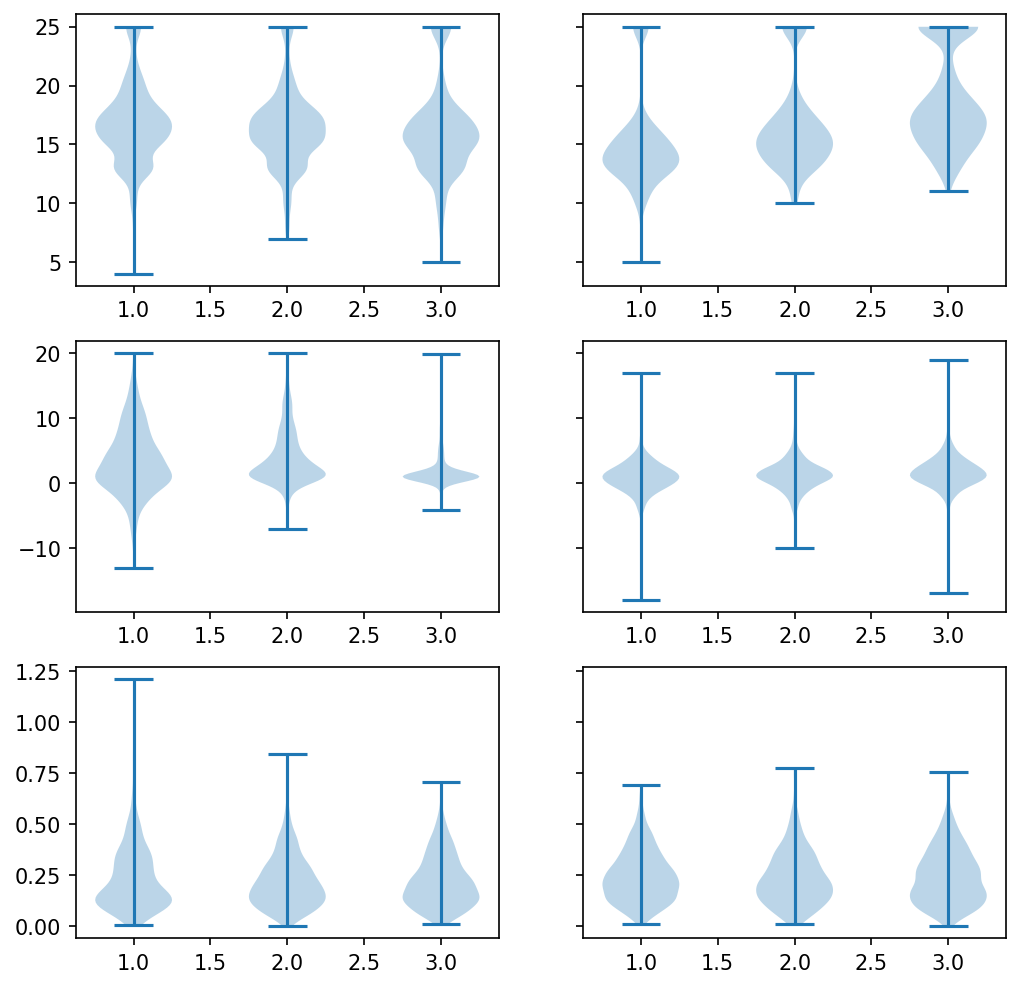

In [61]:
import matplotlib.pyplot as plt

unconstrained_df = pd.DataFrame()
unconstrained_df.index = ['Length', 'Charge', 'Hydrophobic moment']
fig, axes = plt.subplots(3, 2, figsize=(8, 8), dpi=150, sharey='row')


for row, attr in enumerate(['Length', 'Charge', 'Hydrophobic moment']):
    for column, model in enumerate(['IWAE', 'AR-VAE']):
        data = []
        for shift in [-4, 0, 4]:
            data.append(results[model][attr][shift][attr])
            unconstrained_df.loc[attr, f'{model} + {shift}'] =  np.mean(results[model][attr][shift][attr])
        axes[row, column].violinplot(data)
    

plt.show()


In [66]:
unconstrained_df.T

,Length,Charge,Hydrophobic moment
IWAE + -4,16.770128,3.433315,0.236561
IWAE + 0,16.342615,3.879875,0.220496
IWAE + 4,16.099143,2.169784,0.222467
AR-VAE + -4,14.830588,1.064675,0.245466
AR-VAE + 0,16.365385,1.280798,0.237586
AR-VAE + 4,18.741304,1.756579,0.244233


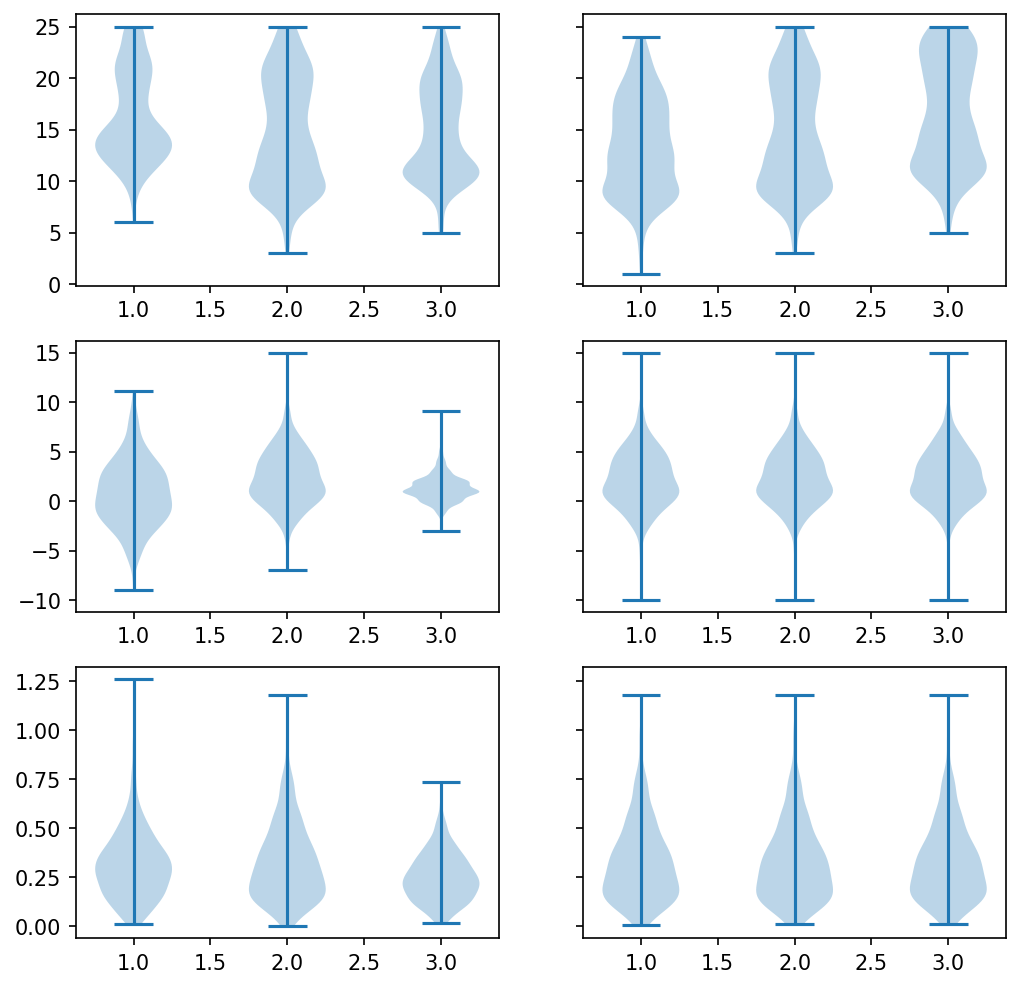

In [68]:
import matplotlib.pyplot as plt

analog_df = pd.DataFrame()
analog_df.index = ['Length', 'Charge', 'Hydrophobic moment']
fig, axes = plt.subplots(3, 2, figsize=(8, 8), dpi=150, sharey='row')


for row, attr in enumerate(['Length', 'Charge', 'Hydrophobic moment']):
    for column, model in enumerate(['IWAE', 'AR-VAE']):
        data = []
        for shift in [-4, 0, 4]:
            data.append(results_analog[model][attr][shift][attr])
            analog_df.loc[attr, f'{model} + {shift}'] =  np.mean(results_analog[model][attr][shift][attr])
        axes[row, column].violinplot(data)
    

plt.show()


In [69]:
analog_df.T.

,Length,Charge,Hydrophobic moment
IWAE + -4,16.232422,0.776492,0.314567
IWAE + 0,14.660156,2.273223,0.328095
IWAE + 4,14.730469,1.325654,0.250890
AR-VAE + -4,13.361328,2.151146,0.327428
AR-VAE + 0,14.662109,2.280227,0.328130
AR-VAE + 4,16.478516,2.383830,0.329871


In [15]:
peptides.shape

torch.Size([25, 512])

In [34]:
np.mean(results['AR-VAE']['Charge'][-5]['charge']), np.mean(results['AR-VAE']['Charge'][0]['charge']), np.mean(results['AR-VAE']['Charge'][5]['charge'])

(1.0371259418729817, 1.234125, 1.7446390086206895)

In [8]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    # physchem['pi'] = []
    # physchem['aromacity'] = []
    # physchem['hydrophobicity'] = []
    physchem['hm'] = []


    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

## Charge ARVAE

In [ ]:
sequences_arvae_right = pd.read_csv('sequences_dim0_2.csv', header=None)
sequences_arvae_right[0] = sequences_arvae_right[0].str.strip().str.rstrip("0")
df_arvae_right = sequences_arvae_right[~sequences_arvae_right[0].str.contains("0")]
generated_arvae_right = df_arvae_right[0].tolist()

sequences_arvae = pd.read_csv('sequences.csv', header=None)
sequences_arvae[0] = sequences_arvae[0].str.strip().str.rstrip("0")
df_arvae = sequences_arvae[~sequences_arvae[0].str.contains("0")]
generated_arvae = df_arvae[0].tolist()

sequences_arvae_left = pd.read_csv('sequences_dim0_-2.csv', header=None)
sequences_arvae_left[0] = sequences_arvae_left[0].str.strip().str.rstrip("0")
df_arvae_left = sequences_arvae_left[~sequences_arvae_left[0].str.contains("0")]
generated_arvae_left = df_arvae_left[0].tolist()

peptides_arvae_lr = calculate_physchem([generated_arvae_left, generated_arvae, generated_arvae_right], ['AR-VAE generated z from left','AR-VAE generated', 'AR-VAE generated z from right'])

In [8]:
chosen_columns = ['charge', 'hm','length']

mean_values_by_dataset = peptides_arvae_lr.groupby('dataset')[chosen_columns].mean()

In [9]:
mean_values_by_dataset

,charge,hm,length
dataset,,,
AR-VAE generated,1.584949,0.239679,16.363443
AR-VAE generated z from left,0.696244,0.119500,17.528954
AR-VAE generated z from right,3.280297,0.168733,16.497100


## Length ARVAE

In [10]:
sequences_arvae_right = pd.read_csv('sequences_dim2_2.csv', header=None)
sequences_arvae_right[0] = sequences_arvae_right[0].str.strip().str.rstrip("0")
df_arvae_right = sequences_arvae_right[~sequences_arvae_right[0].str.contains("0")]
generated_arvae_right = df_arvae_right[0].tolist()

sequences_arvae_left = pd.read_csv('sequences_dim2_-2.csv', header=None)
sequences_arvae_left[0] = sequences_arvae_left[0].str.strip().str.rstrip("0")
df_arvae_left = sequences_arvae_left[~sequences_arvae_left[0].str.contains("0")]
generated_arvae_left = df_arvae_left[0].tolist()

peptides_arvae_lr = calculate_physchem([generated_arvae_left, generated_arvae_right], ['AR-VAE generated z from left', 'AR-VAE generated z from right'])

In [11]:
chosen_columns = ['charge', 'hm','length']

mean_values_by_dataset = peptides_arvae_lr.groupby('dataset')[chosen_columns].mean()

In [12]:
mean_values_by_dataset

,charge,hm,length
dataset,,,
AR-VAE generated z from left,1.199282,0.170188,12.461041
AR-VAE generated z from right,-1.122411,0.226968,14.670575


## Charge IWAE

In [30]:
sequences_arvae_right = pd.read_csv('sequences_dim0_2_iwae.csv', header=None)
sequences_arvae_right[0] = sequences_arvae_right[0].str.strip().str.rstrip("0")
df_arvae_right = sequences_arvae_right[~sequences_arvae_right[0].str.contains("0")]
generated_arvae_right = df_arvae_right[0].tolist()

sequences_arvae = pd.read_csv('sequences_iwae.csv', header=None)
sequences_arvae[0] = sequences_arvae[0].str.strip().str.rstrip("0")
df_arvae = sequences_arvae[~sequences_arvae[0].str.contains("0")]
generated_arvae = df_arvae[0].tolist()

sequences_arvae_left = pd.read_csv('sequences_dim0_-2_iwae.csv', header=None)
sequences_arvae_left[0] = sequences_arvae_left[0].str.strip().str.rstrip("0")
df_arvae_left = sequences_arvae_left[~sequences_arvae_left[0].str.contains("0")]
generated_arvae_left = df_arvae_left[0].tolist()

peptides_arvae_lr = calculate_physchem([generated_arvae_left, generated_arvae, generated_arvae_right], ['IWAE generated z from left','IWAE generated', 'IWAE generated z from right'])

In [31]:
chosen_columns = ['charge', 'hm','length']

mean_values_by_dataset = peptides_arvae_lr.groupby('dataset')[chosen_columns].mean()

In [32]:
mean_values_by_dataset

,charge,hm,length
dataset,,,
IWAE generated,3.720164,0.225772,16.142686
IWAE generated z from left,0.996125,0.214986,12.893562
IWAE generated z from right,8.432571,0.306684,15.594075


## Length IWAE

In [23]:
sequences_arvae_right = pd.read_csv('sequences_dim2_2_iwae.csv', header=None)
sequences_arvae_right[0] = sequences_arvae_right[0].str.strip().str.rstrip("0")
df_arvae_right = sequences_arvae_right[~sequences_arvae_right[0].str.contains("0")]
generated_arvae_right = df_arvae_right[0].tolist()

sequences_arvae_left = pd.read_csv('sequences_dim2_-2_iwae.csv', header=None)
sequences_arvae_left[0] = sequences_arvae_left[0].str.strip().str.rstrip("0")
df_arvae_left = sequences_arvae_left[~sequences_arvae_left[0].str.contains("0")]
generated_arvae_left = df_arvae_left[0].tolist()

peptides_arvae_lr = calculate_physchem([generated_arvae_left, generated_arvae_right], ['AR-VAE generated z from left', 'AR-VAE generated z from right'])

In [24]:
chosen_columns = ['charge', 'hm','length']

mean_values_by_dataset = peptides_arvae_lr.groupby('dataset')[chosen_columns].mean()

In [25]:
mean_values_by_dataset

,charge,hm,length
dataset,,,
AR-VAE generated z from left,6.627409,0.190245,11.663338
AR-VAE generated z from right,9.017156,0.187780,17.050000
